In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [3]:

import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.math import log , reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.callbacks import History
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

2024-05-18 23:44:55.197992: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 23:44:55.217091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 23:44:55.217113: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 23:44:55.217127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 23:44:55.220889: I tensorflow/core/platform/cpu_feature_g

In [4]:
# import opendatasets as od


In [5]:
# Assign the Kaggle data set URL into variable
# dataset = 'https://www.kaggle.com/datasets/hs181001/bk-isut-dataset'
# Using opendatasets let's download the data sets
# od.download(dataset)

In [6]:
import keras
keras.__version__

'2.14.0'

In [7]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [8]:
import albumentations as A

In [9]:
print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, running on CPU instead.")

TensorFlow version: 2.14.0
Pandas version: 2.1.1
Numpy version: 1.26.0
1 Physical GPUs, 1 Logical GPUs


2024-05-18 23:45:04.623536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 23:45:04.626308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 23:45:04.626384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
save_train_image_dataset_path = './bk-isut-dataset/train_image_dataset.npy'
save_val_image_dataset_path = './bk-isut-dataset/val_image_dataset.npy'
save_test_image_dataset_path = './bk-isut-dataset/test_image_dataset.npy'
save_train_mask_image_dataset_path = './bk-isut-dataset/mask_train_image_dataset.npy'
save_val_mask_image_dataset_path = './bk-isut-dataset/mask_val_image_dataset.npy'
save_test_mask_image_dataset_path = './bk-isut-dataset/mask_test_image_dataset.npy'

In [11]:
X_train = np.load(save_train_image_dataset_path, mmap_mode='c')
X_val = np.load(save_val_image_dataset_path, mmap_mode='c')
X_test = np.load(save_test_image_dataset_path, mmap_mode='c')
y_train = np.load(save_train_mask_image_dataset_path, mmap_mode='c')
y_val = np.load(save_val_mask_image_dataset_path, mmap_mode='c')
y_test = np.load(save_test_mask_image_dataset_path, mmap_mode='c')

In [12]:
# Define the augmentation function
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation(height, width):
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.6, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0, value=0),
        A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0, value=0),
        A.RandomCrop(height=height, width=width, always_apply=True),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

In [13]:
# Function to apply augmentation
def augment_data(image, mask):
    aug = get_training_augmentation(256, 256)(image=image, mask=mask)
    aug_image = aug['image'].astype(np.uint8)
    aug_mask = aug['mask'].astype(np.uint8)
    return aug_image, aug_mask

# Wrap the augmentation function for TensorFlow
def tf_augment_data(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=augment_data, inp=[image, mask], Tout=[tf.uint8, tf.uint8])
    return aug_img, aug_mask

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [15]:
def _normalize(X_batch, y_batch):
  X_batch = tf.cast(X_batch, tf.float32)
  y_batch = tf.cast(y_batch, tf.float32)
  return X_batch, y_batch


In [16]:
# Create augmented dataset
# augmented_train_dataset = train_dataset.map(tf_augment_data)

In [17]:
# Combine normal and augmented datasets
# combined_train_dataset = train_dataset.concatenate(augmented_train_dataset)

In [18]:
# Normalize and batch the datasets
train_dataset = train_dataset.map(_normalize).batch(16)
val_dataset = val_dataset.batch(16).map(_normalize)

In [19]:
checkpoint_path = "unet_resnet34/cp.weights.h5"

In [20]:
BACKBONE1 = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE1)

# preprocess input
train_dataset = preprocess_input(train_dataset)
val_dataset = preprocess_input(val_dataset)


In [21]:
model = sm.Unet('resnet34', encoder_weights=False, classes=5, activation='softmax')
model.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score],)

In [22]:
# gpus = tf.config.list_logical_devices('GPU')
# strategy = tf.distribute.MirroredStrategy(gpus)

In [23]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                             monitor='val_loss',
                                             save_best_only=True,
                                             save_weights_only=True,
                                             verbose=1)
]


# model = tf.keras.models.load_model('my_model_with_batch_image.keras')
history = model.fit(
   train_dataset,
   epochs=200,
   validation_data=val_dataset,
   callbacks=callbacks,
)

Epoch 1/200


2024-05-18 23:45:11.929600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-05-18 23:45:11.995401: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-18 23:45:12.081852: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-18 23:45:13.146801: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7aeb9d4f1bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-18 23:45:13.146822: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-18 23:45:13.149213: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-18 23:45:13.183736: I ./tensorflow/compiler/jit/device_comp

195/195 [==============================] - ETA: 0s - loss: 0.4572 - iou_score: 0.4248
Epoch 1: val_loss improved from inf to 0.62421, saving model to unet_resnet34/cp.weights.h5
195/195 [==============================] - 28s 93ms/step - loss: 0.4572 - iou_score: 0.4248 - val_loss: 0.6242 - val_iou_score: 0.2773
Epoch 2/200
194/195 [============================>.] - ETA: 0s - loss: 0.3838 - iou_score: 0.4952
Epoch 2: val_loss improved from 0.62421 to 0.49637, saving model to unet_resnet34/cp.weights.h5
195/195 [==============================] - 14s 73ms/step - loss: 0.3842 - iou_score: 0.4947 - val_loss: 0.4964 - val_iou_score: 0.4111
Epoch 3/200
195/195 [==============================] - ETA: 0s - loss: 0.3643 - iou_score: 0.5140
Epoch 3: val_loss improved from 0.49637 to 0.42150, saving model to unet_resnet34/cp.weights.h5
195/195 [==============================] - 14s 74ms/step - loss: 0.3643 - iou_score: 0.5140 - val_loss: 0.4215 - val_iou_score: 0.4711
Epoch 4/200
194/195 [========

In [24]:
model.load_weights(checkpoint_path)

1/1 [==============================] - 0s 9ms/step


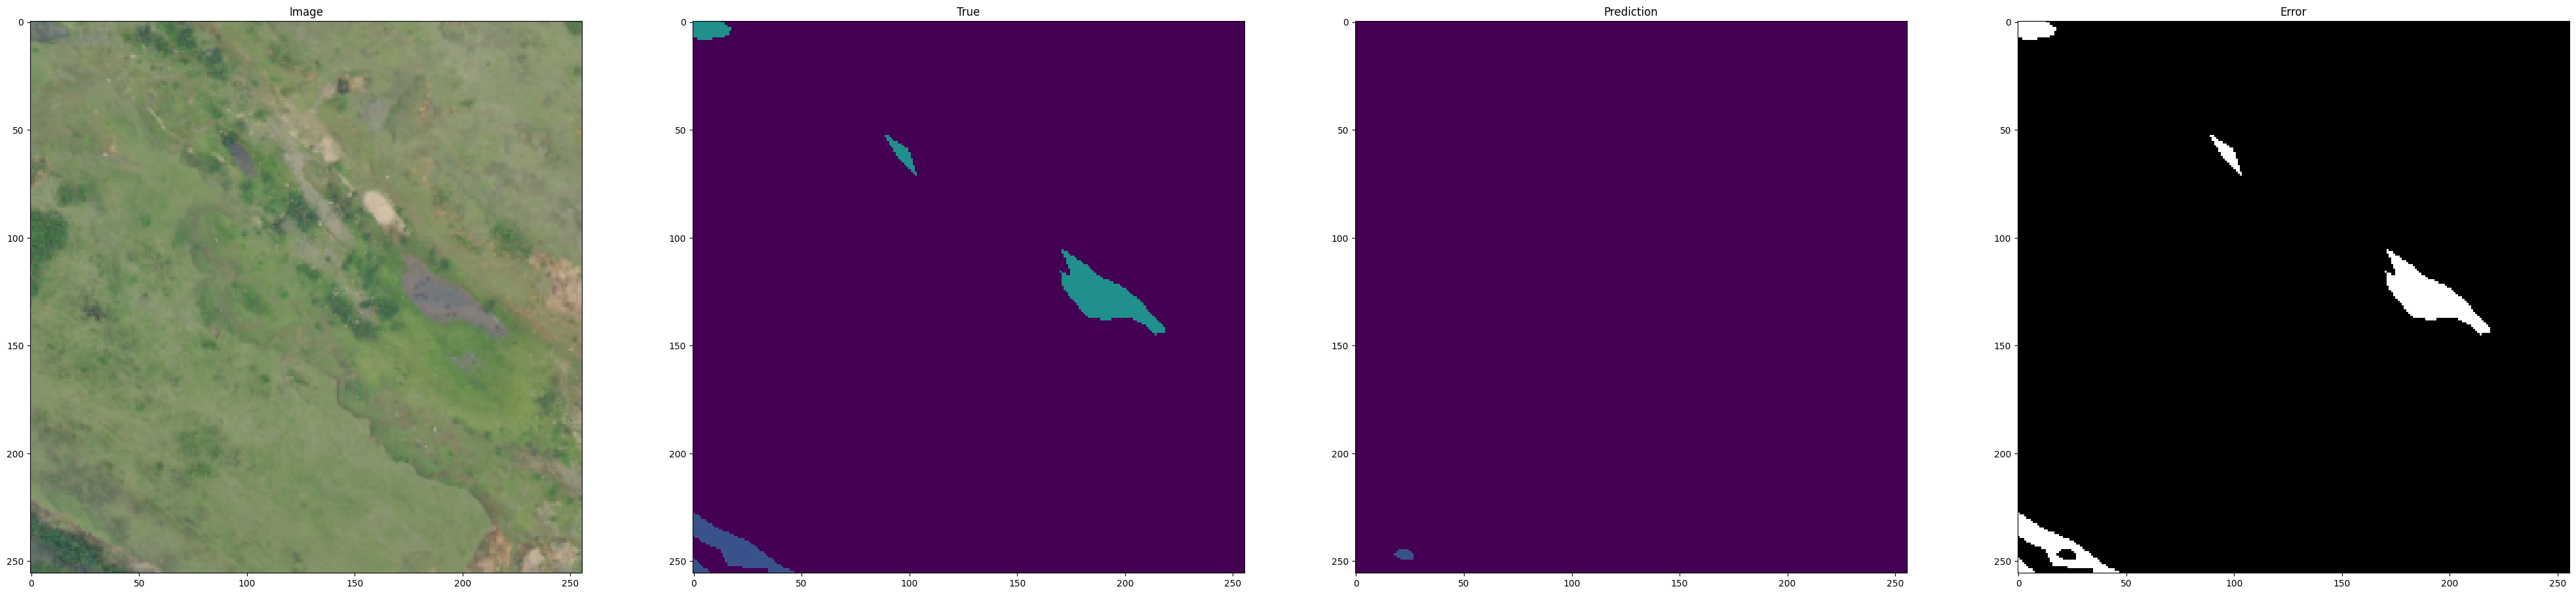

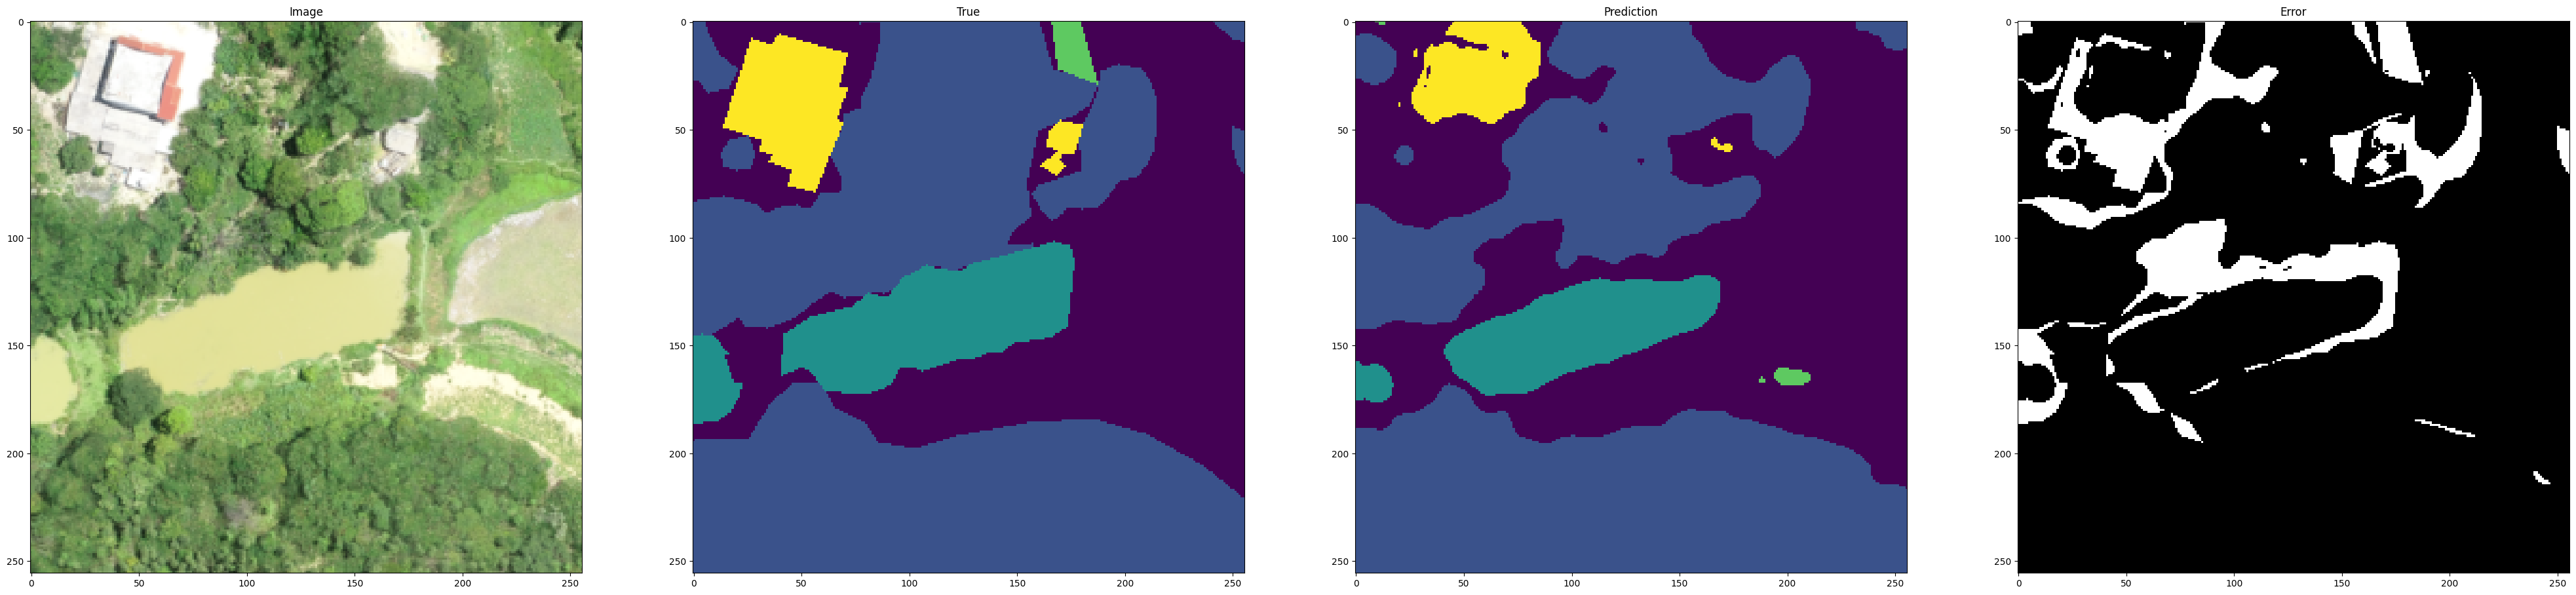

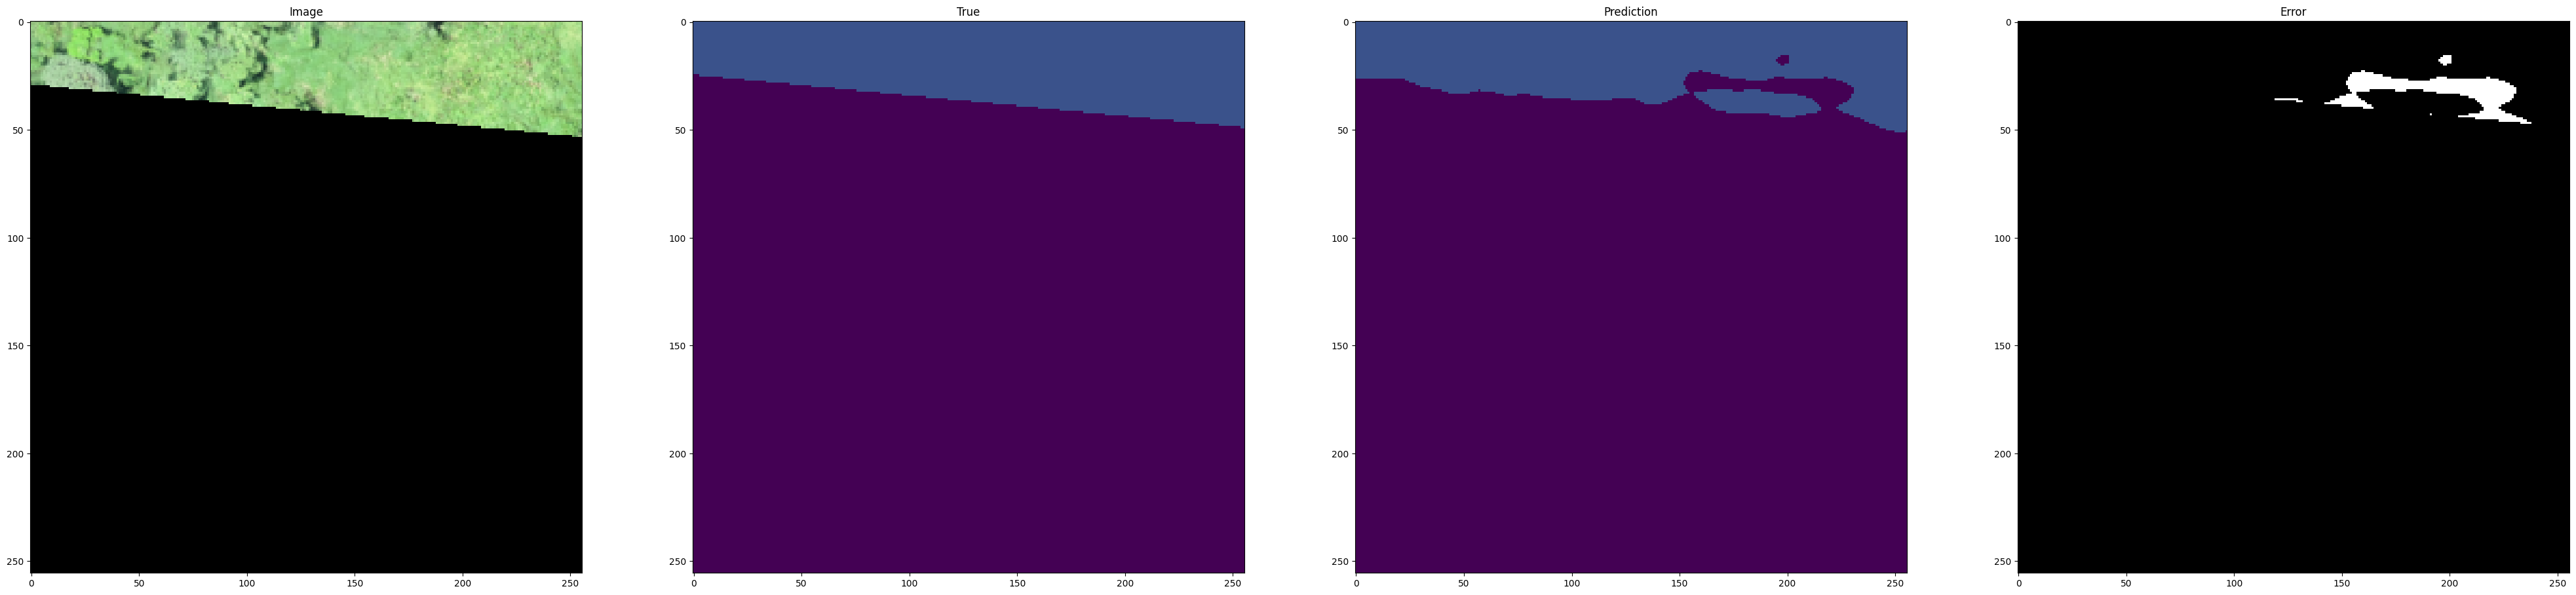

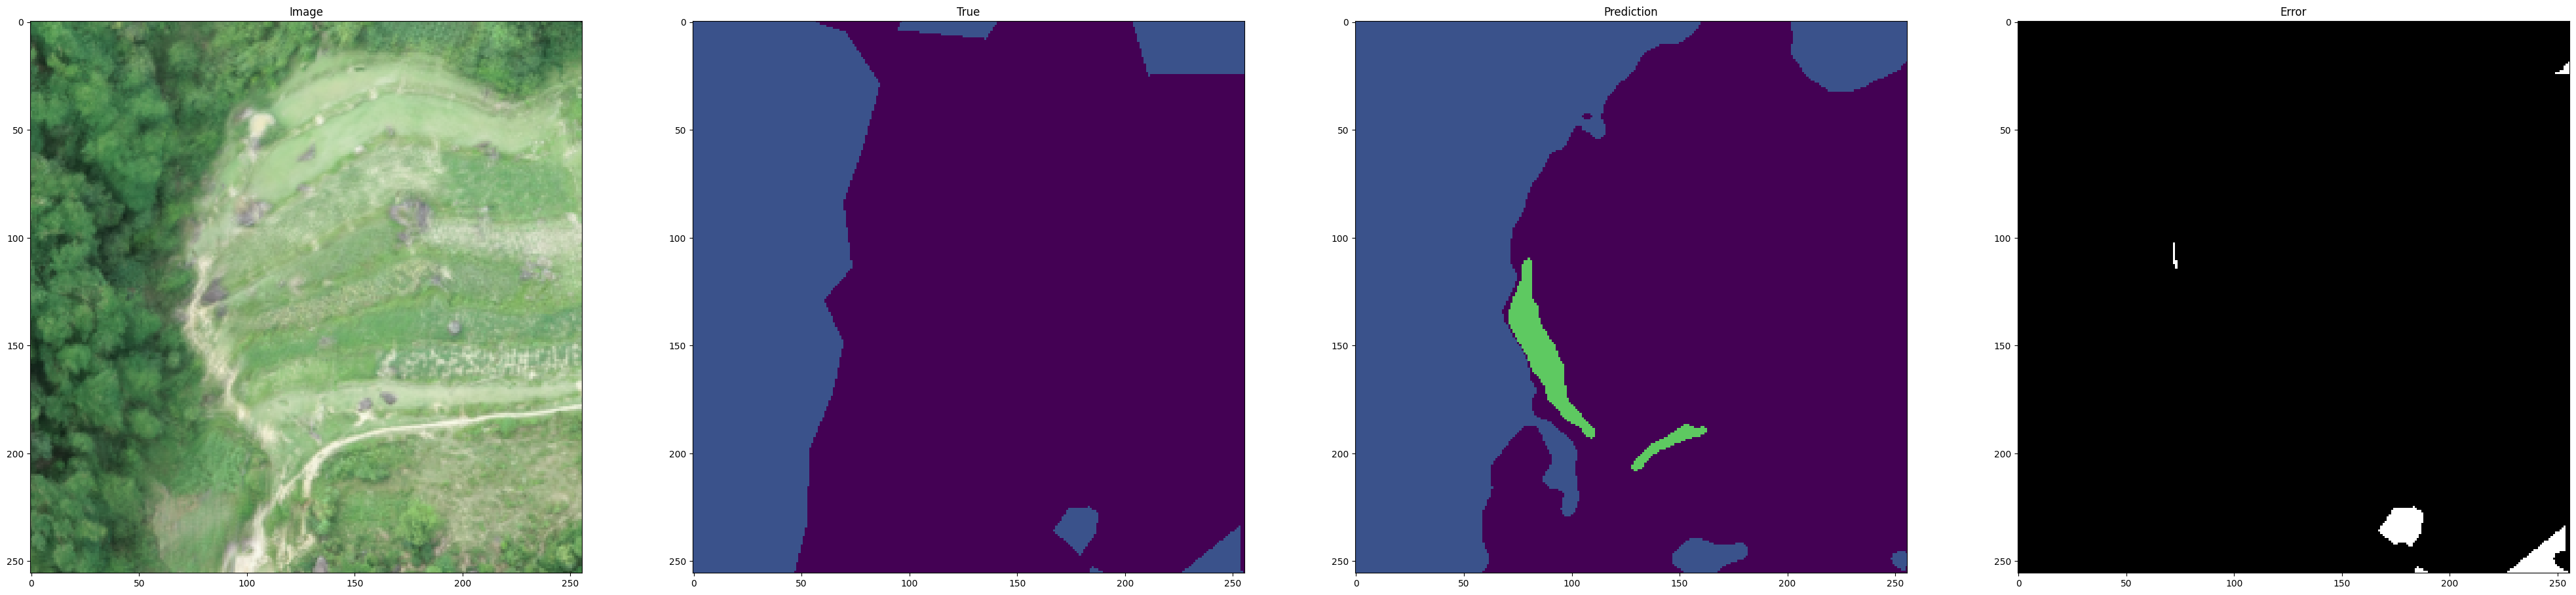

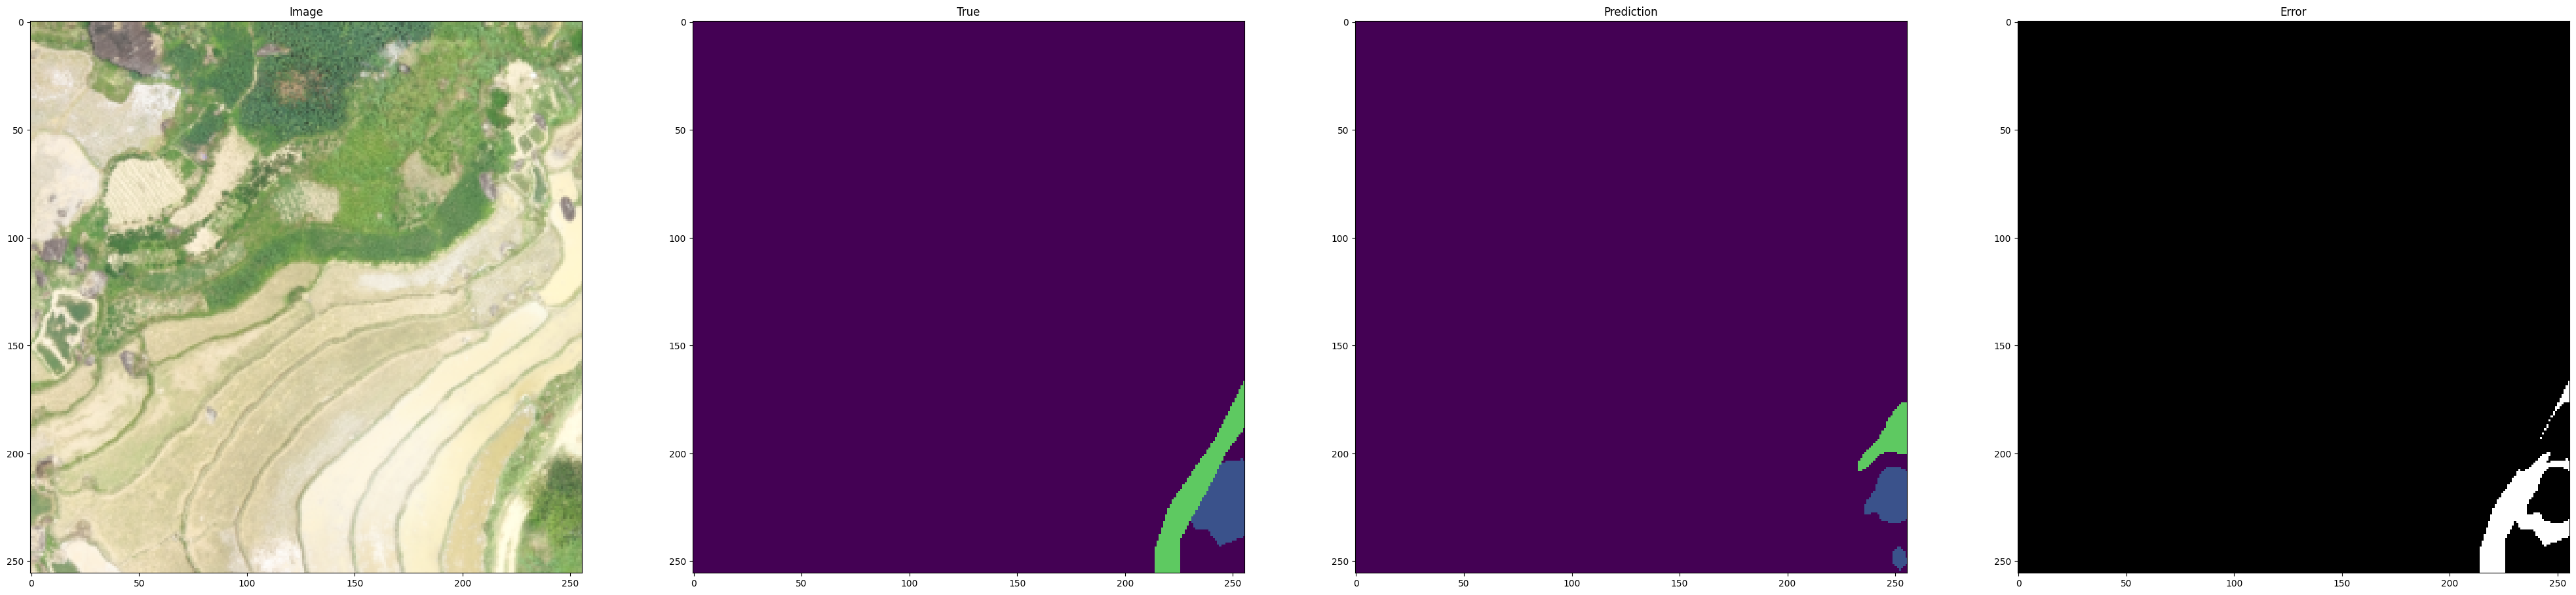

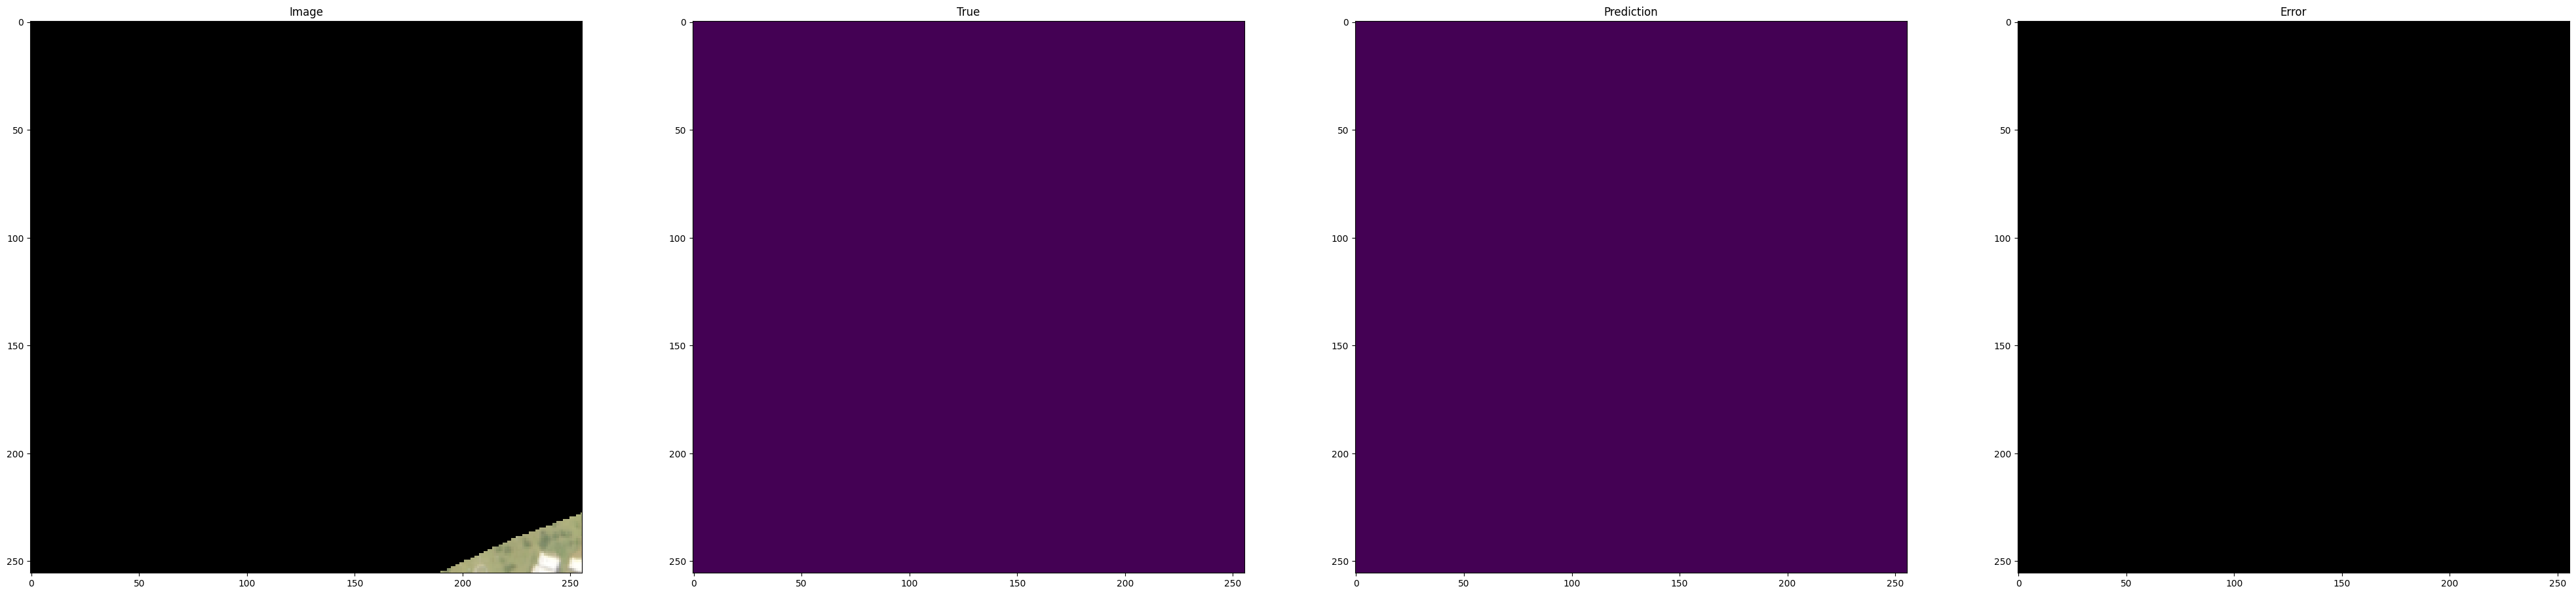

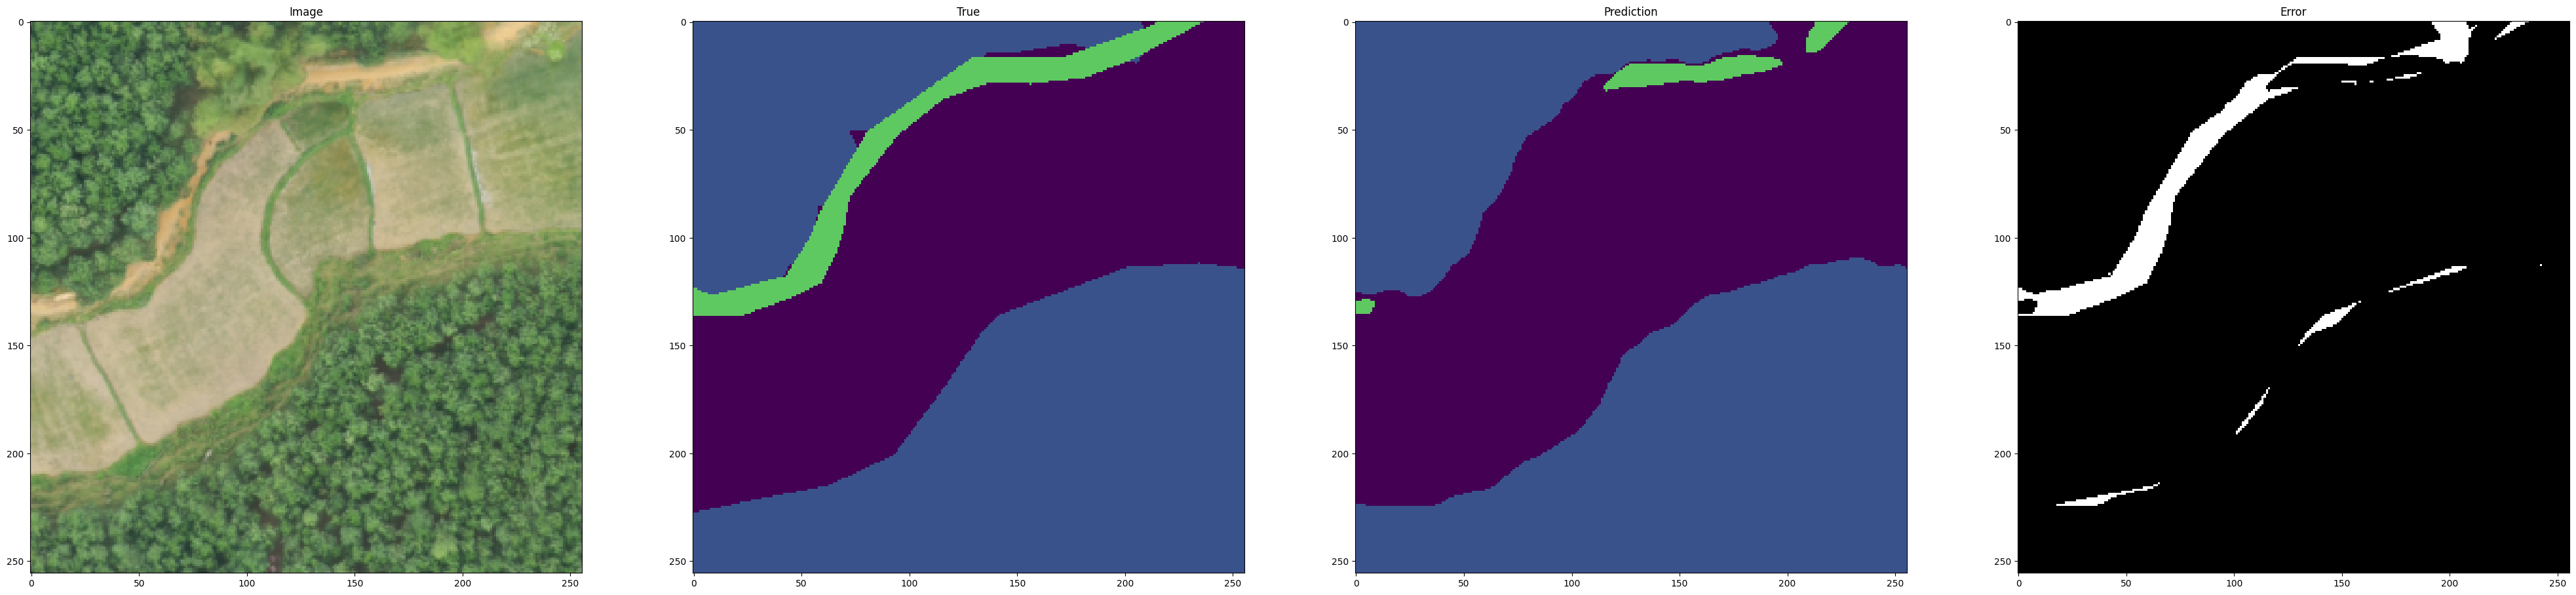

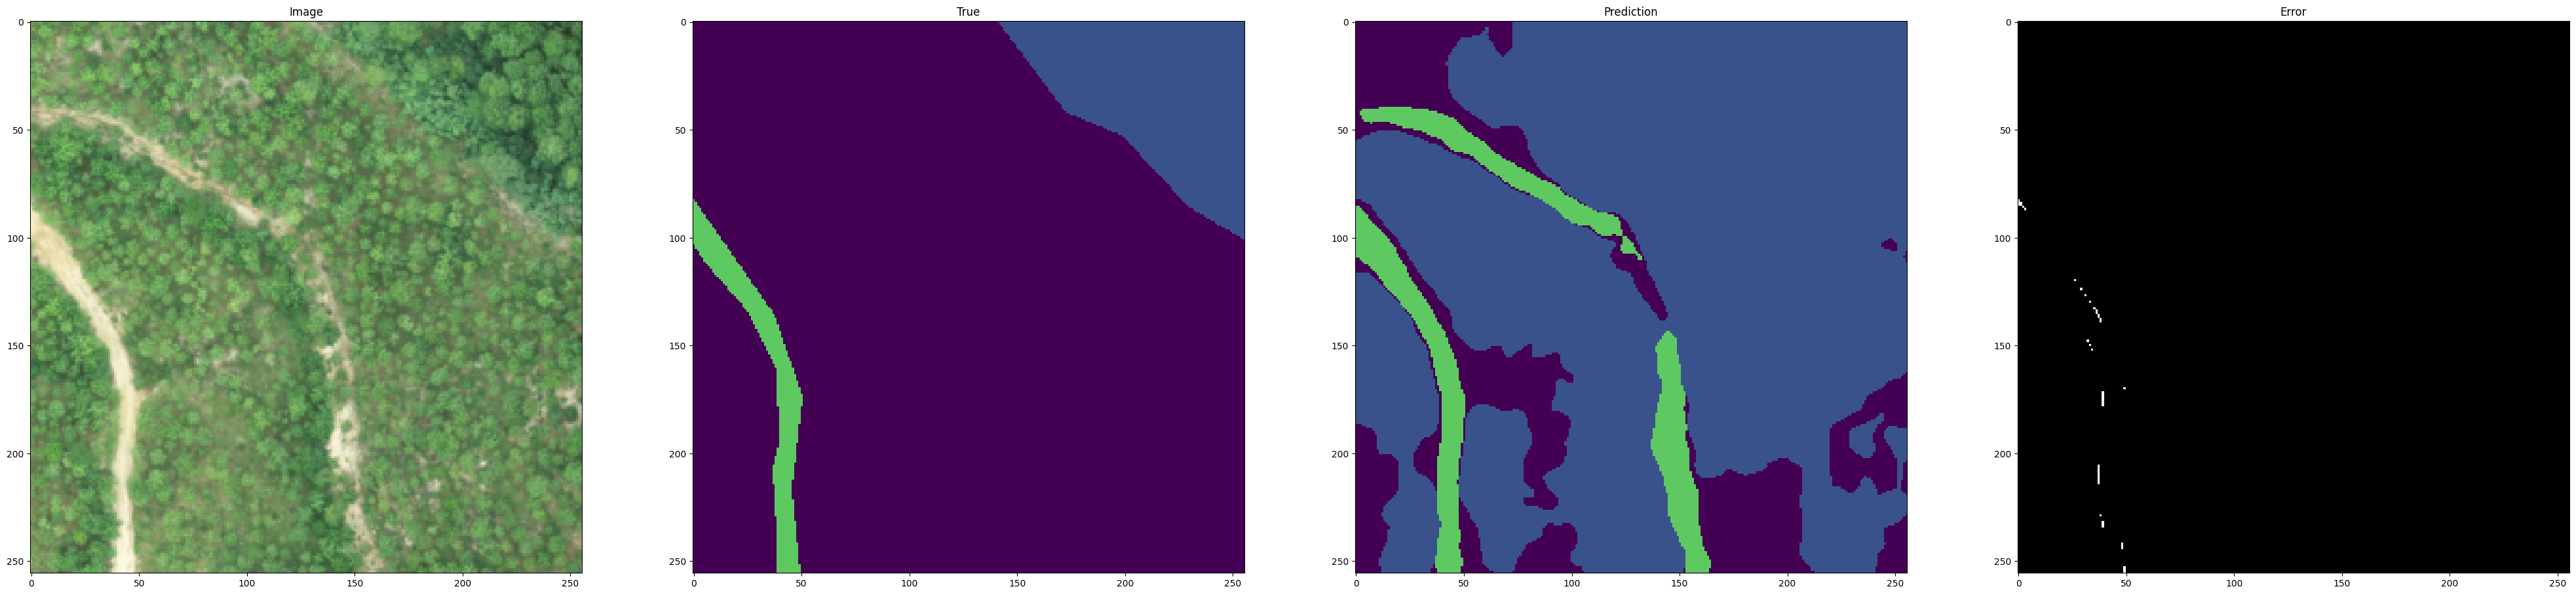

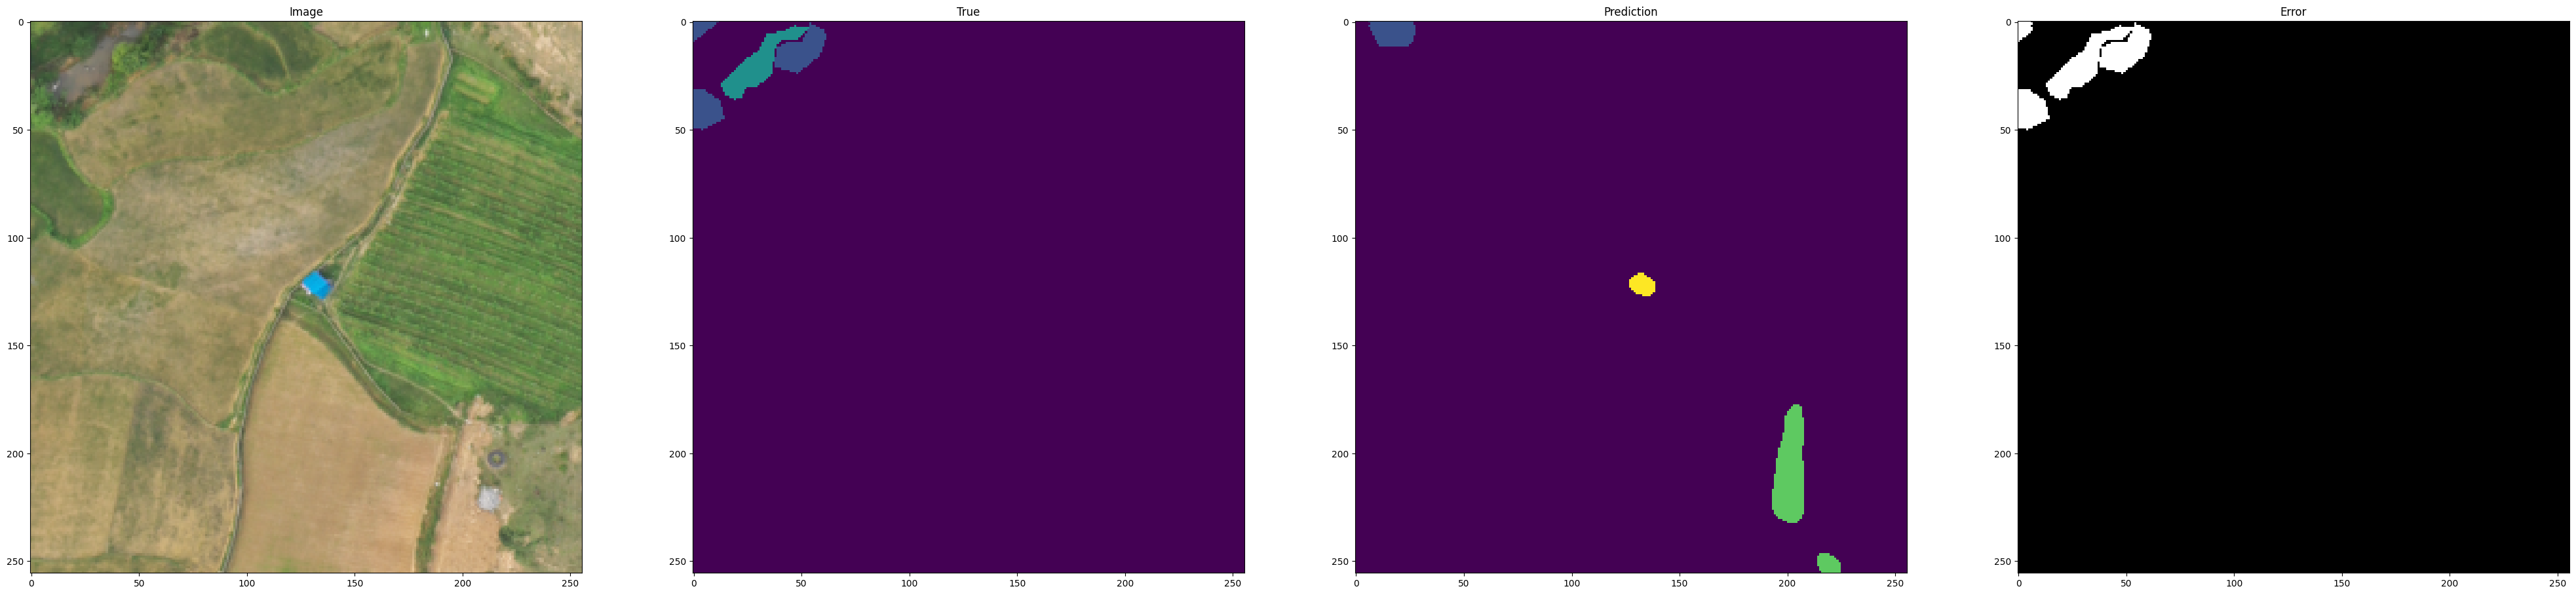

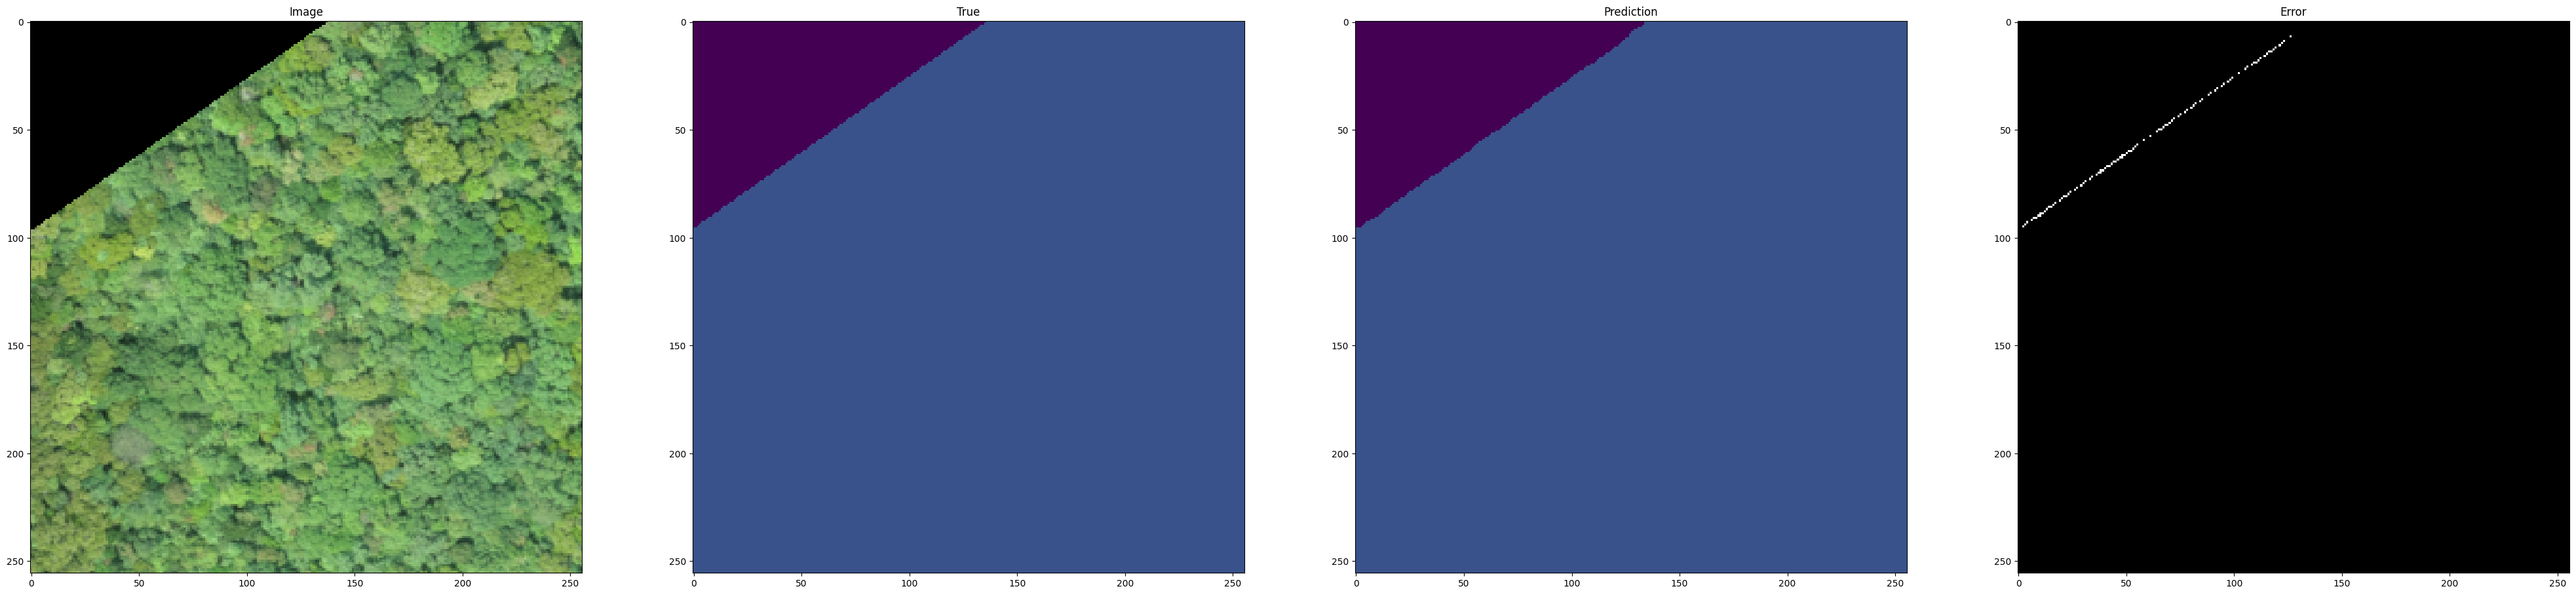

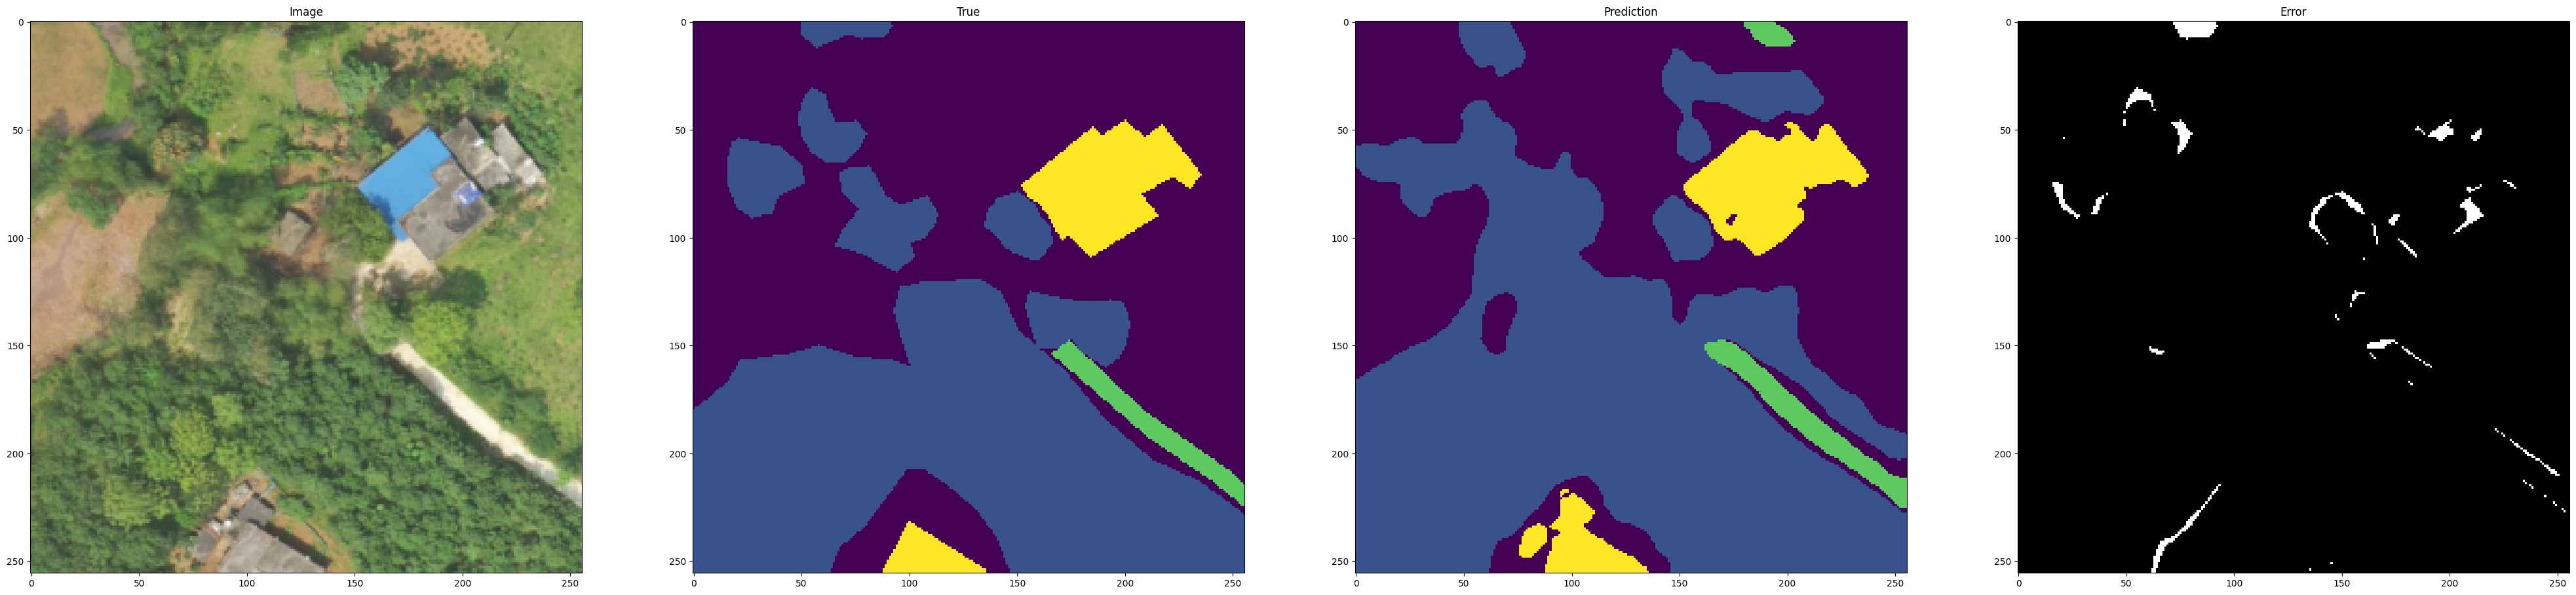

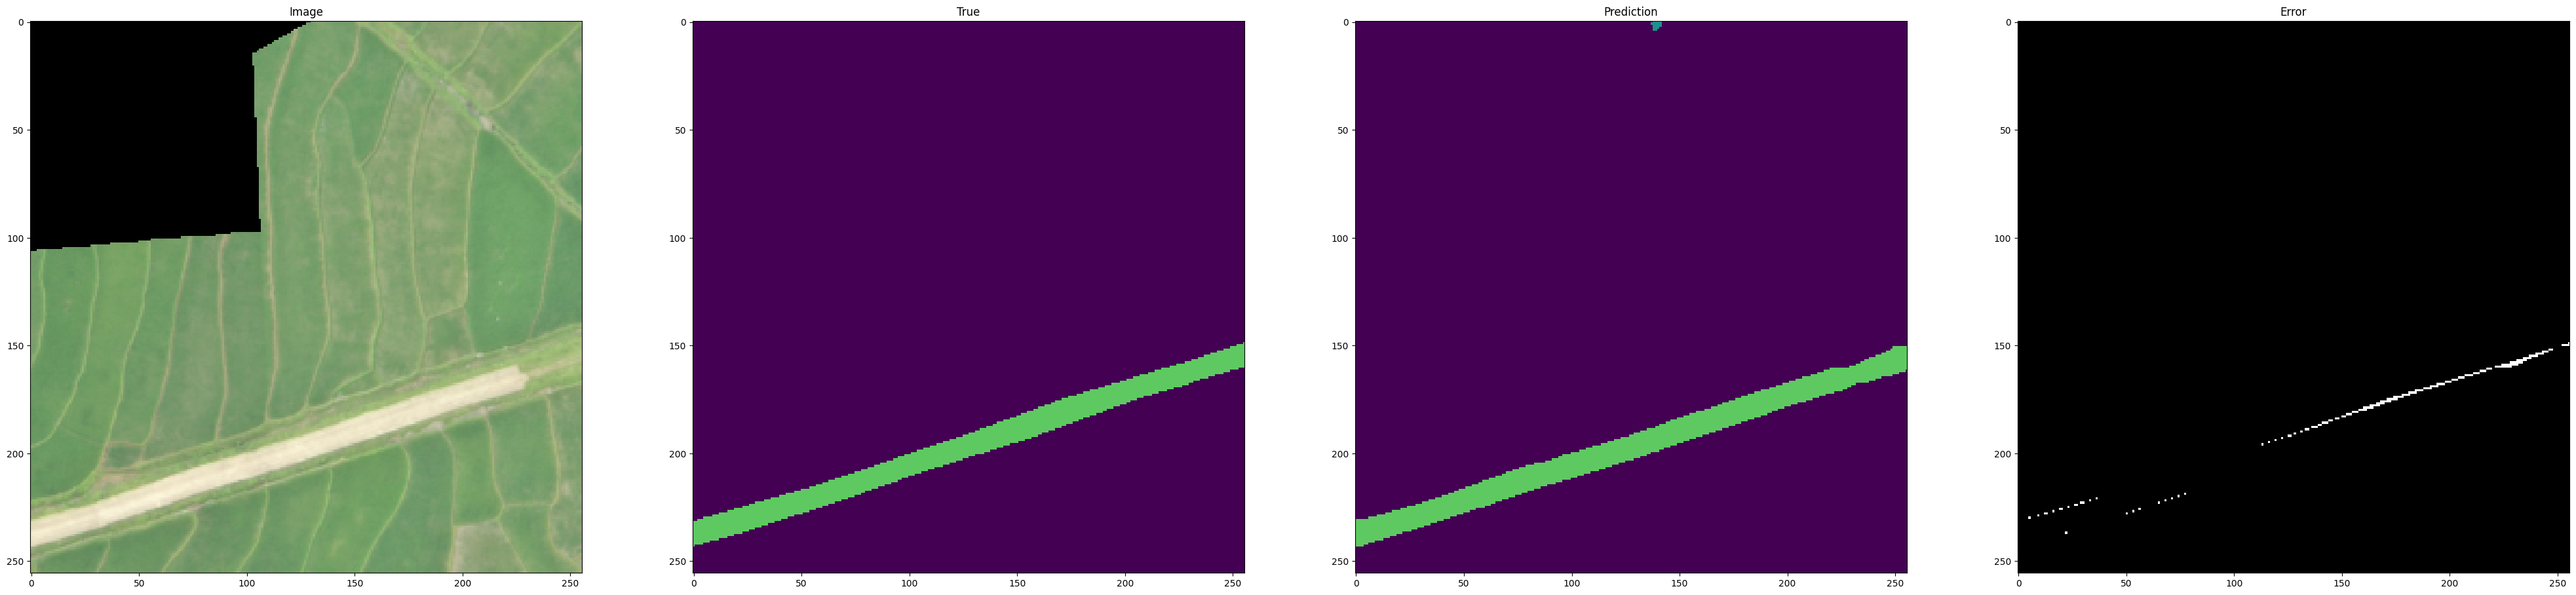

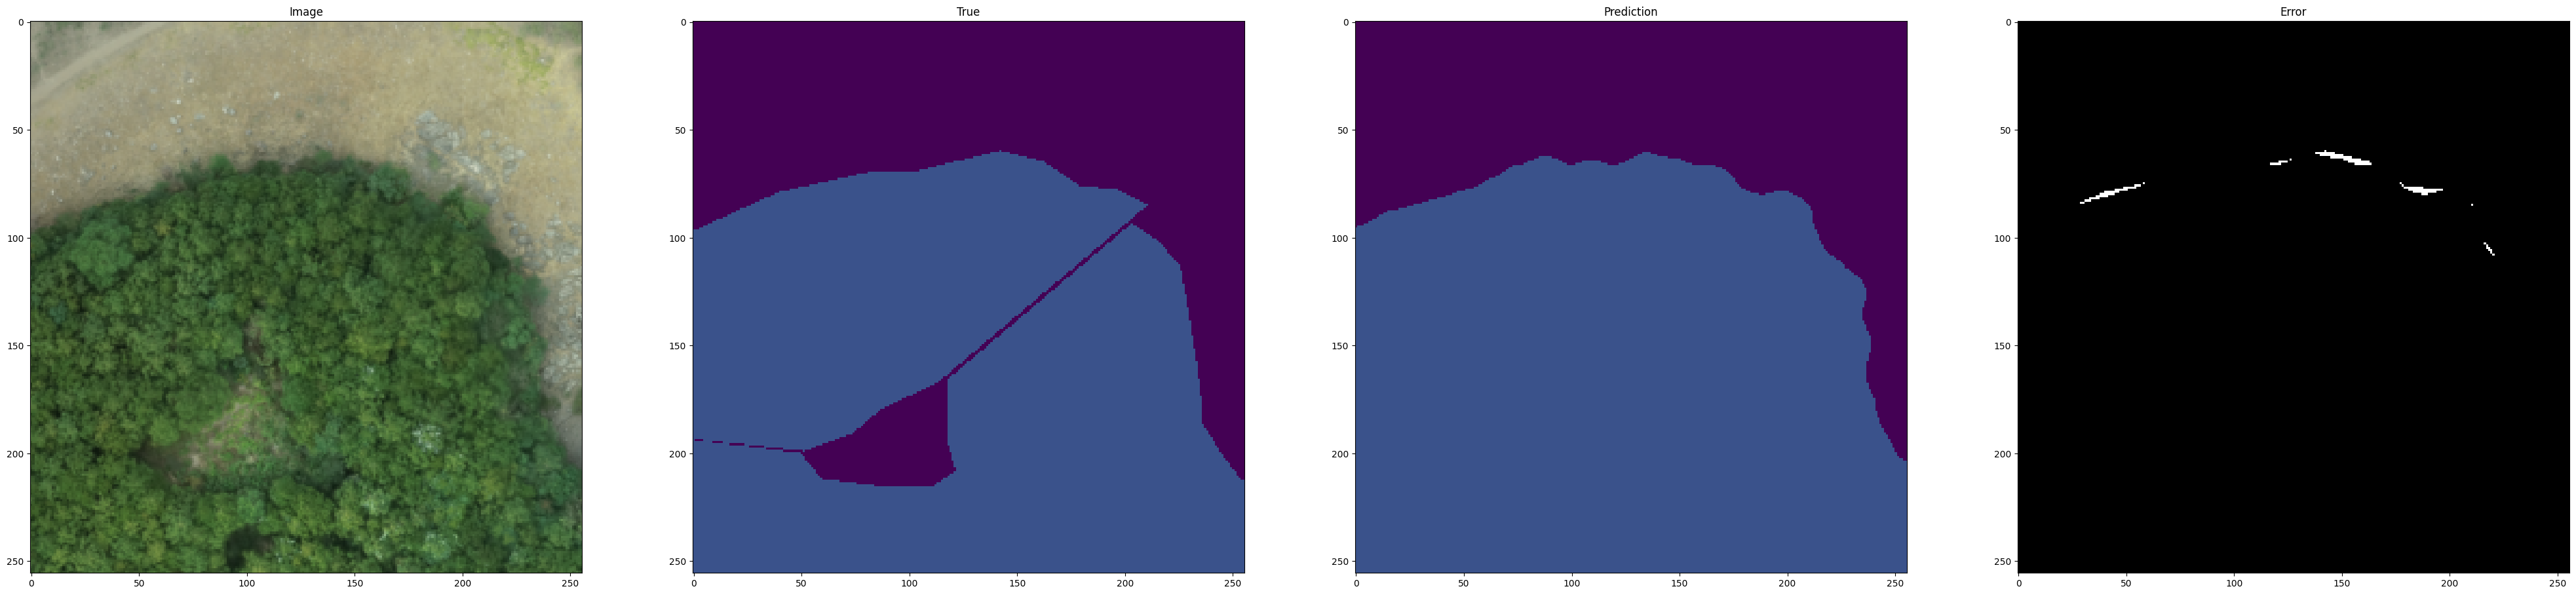

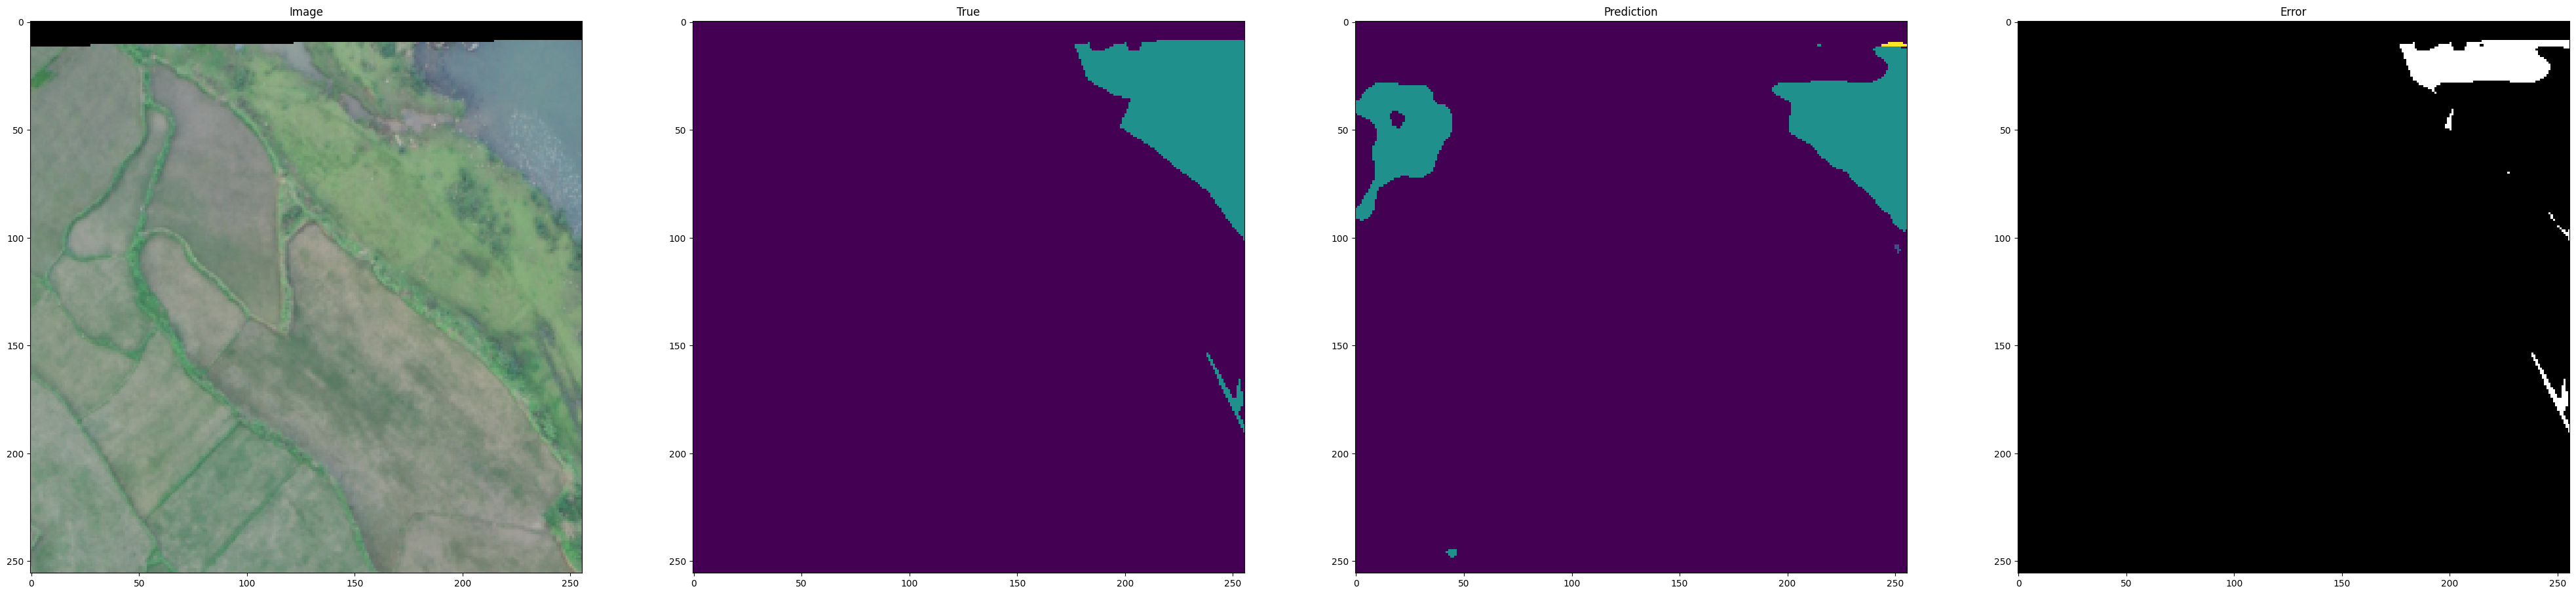

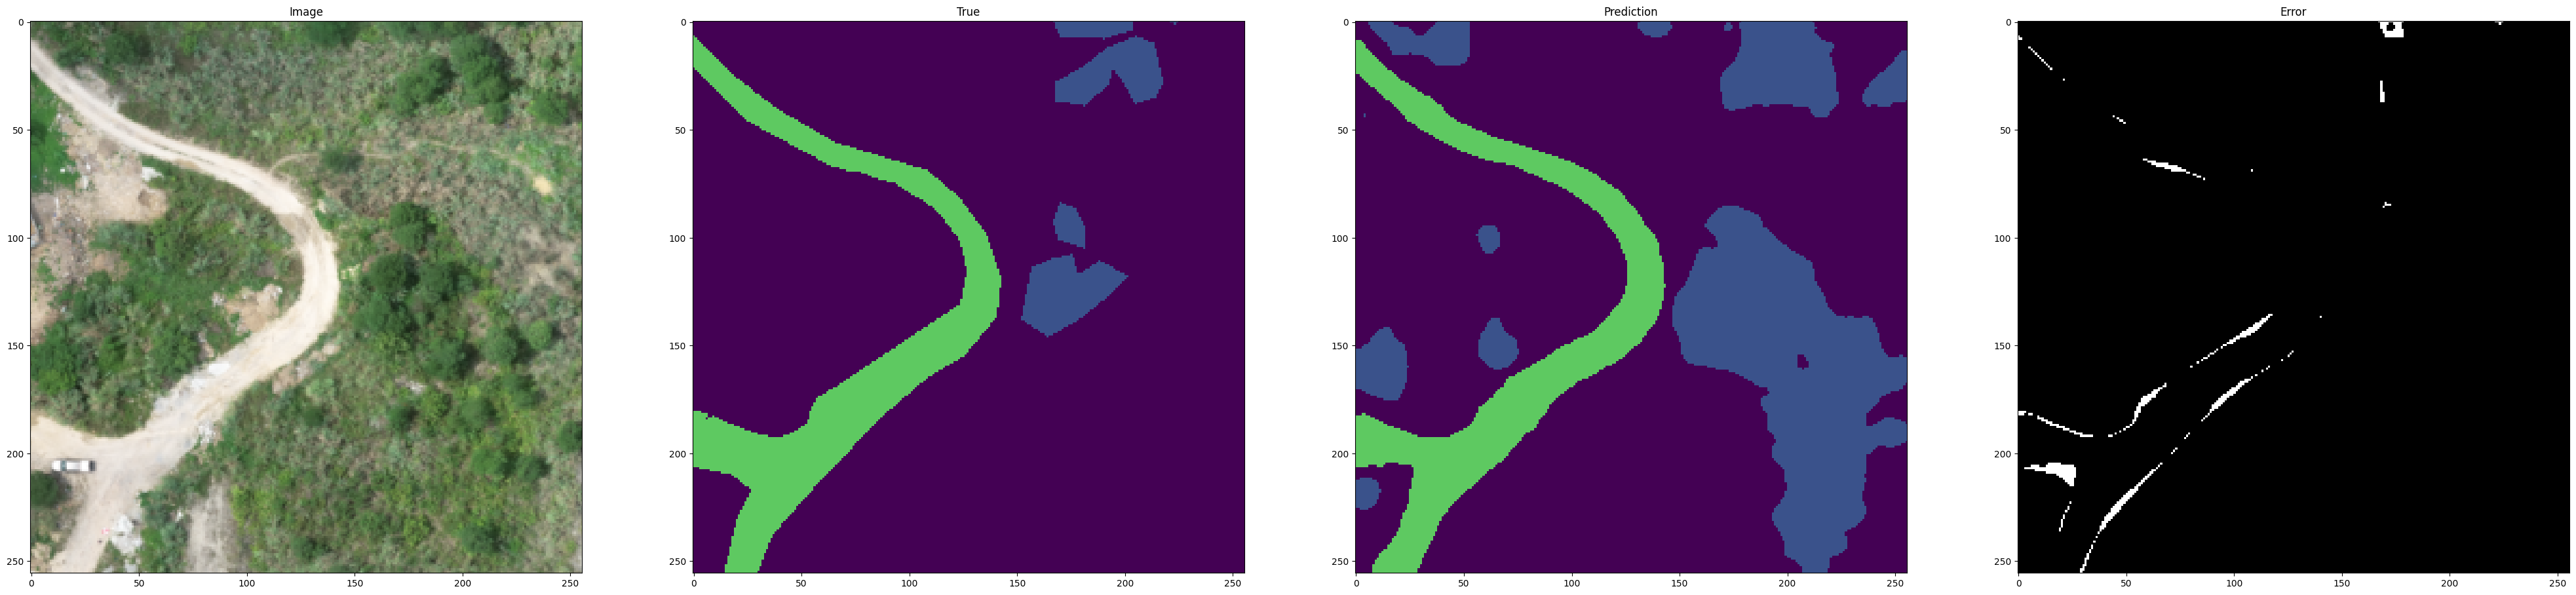

In [25]:
vmin = 0
vmax = 4

for i in range(15):

    image_number = random.randint(0, X_test.shape[0] - 1)

    plt.figure(figsize=(50, 12.5))

    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])

    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)

    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2)  # convert to 0-5 classes

    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype('uint8')
    plt.imshow(error, cmap='gray')

    # print(prediction.shape)
    # print(prediction)
    # print(true.shape)
    # print(true)


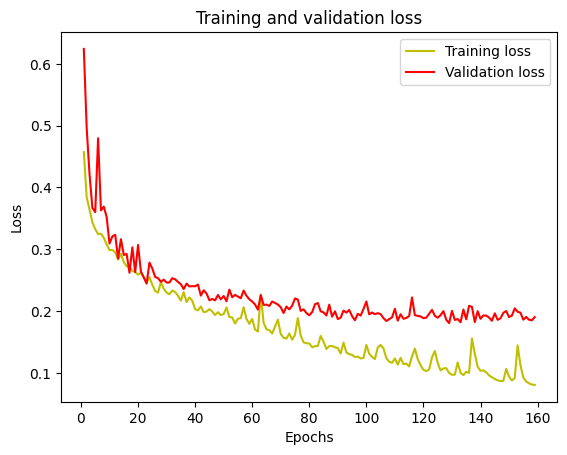

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

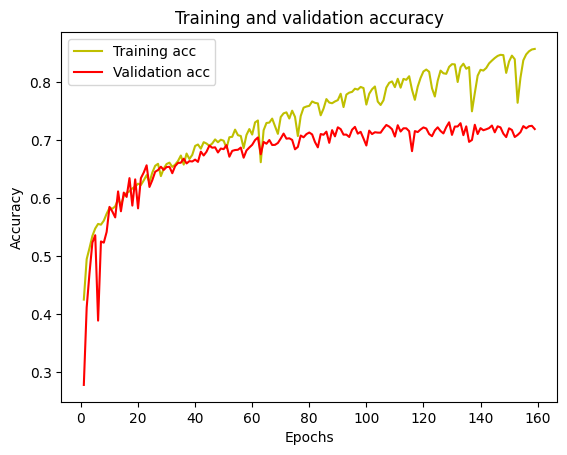

In [27]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# model.save('unet_model_with_focal_loss_resnet34_backbone.keras')

In [29]:
X_pred = []
X_label = []
for i in range(len(X_test)):
  true = y_test[i].argmax(axis=2)
  prediction = model.predict(np.expand_dims(X_test[i], 0))[0].argmax(axis=2)
  X_pred.append(prediction)
  X_label.append(true)

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


In [30]:
X_label = np.array(X_label)
X_pred = np.array(X_pred)

In [31]:
def calculate_iou(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = []

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores.append(0.0)  # Handle the case of no instances of a class
        else:
            iou_scores.append(intersection / union)

    return np.mean(iou_scores)

In [32]:
def calculate_iou_for_each_class(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = {}

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores[class_id] = 0.0  # Handle the case of no instances of a class
        else:
            iou_scores[class_id] = intersection / union

    return iou_scores


iou_scores = calculate_iou_for_each_class(X_label, X_pred)
for class_id, iou in iou_scores.items():
    print("IoU for class", class_id, ":", iou)


IoU for class 0 : 0.8532640283613584
IoU for class 1 : 0.8726219104459126
IoU for class 2 : 0.9006457885801077
IoU for class 3 : 0.562564892304905
IoU for class 4 : 0.6808908933869633


In [33]:
miou = calculate_iou(X_label, X_pred)
print("Mean IoU:", miou)

Mean IoU: 0.7739975026158494
